## Example curve prediction script
In this notebook we will try to predict the function coefficients.

In [88]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from prettytable import PrettyTable
%matplotlib widget

from generate_TF import GenerateTF

# from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F


In [89]:
# Load the data
# df = pd.read_pickle('./data/transfer-functions.pkl')
df = pd.read_pickle('./data/transfer-functions-82000.pkl')
df.head()

,phi,g_oo,x,y
0,-20.0,0.000100,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-22.425862483348567, -34.50558003150795, -39...."
1,-20.0,0.000621,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-17.111296708758623, -19.276097087349733, -21..."
2,-20.0,0.001142,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-37.10041261060839, -21.007891272269745, -20...."
3,-20.0,0.001663,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-23.37838521227782, -24.835608713413627, -24...."
4,-20.0,0.002184,"[-1619443.0, -1614543.0211800302, -1609643.042...","[-21.79184944021594, -28.996907099851697, -27...."


In [90]:
phi_encoder = preprocessing.LabelEncoder()
df['phi_label'] = phi_encoder.fit_transform(df['phi'])
print(phi_encoder.classes_)

gain_encoder = preprocessing.LabelEncoder()
df['g_oo_label'] = gain_encoder.fit_transform(df['g_oo'])
print(gain_encoder.classes_)

print(df.dtypes)

[-20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.
   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.]
[0.0001     0.00062105 0.00114211 0.00166316 0.00218421 0.00270526
 0.00322632 0.00374737 0.00426842 0.00478947 0.00531053 0.00583158
 0.00635263 0.00687368 0.00739474 0.00791579 0.00843684 0.00895789
 0.00947895 0.01      ]
phi           float64
g_oo          float64
x              object
y              object
phi_label       int64
g_oo_label      int64
dtype: object


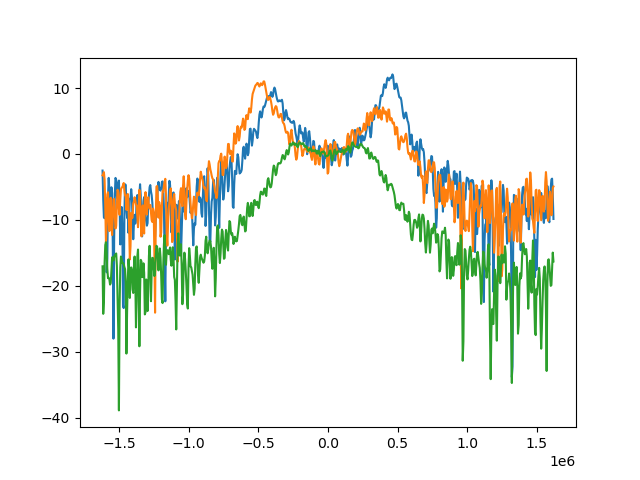

In [91]:
# Visualize the data
for index, row in df.sample(n=3).iterrows():
    y = row['y']
    x = row['x']
    plt.plot(x, y)
plt.show()

In [92]:
# Extract the target variables
param_a_label = df.pop('phi_label')
param_b_label = df.pop('g_oo_label')

param_a = df.pop('phi')
param_b = df.pop('g_oo')

# All x should be equal
x = df.iloc[0].x.astype(np.float32)
df.drop(columns='x', inplace=True)

In [93]:
# target is the target vector
target = np.array((param_a_label, param_b_label), dtype=np.uint8).T

target_original = np.array((param_a, param_b)).T

target = torch.tensor(target, dtype=torch.uint8)
print(target[5:15])

tensor([[ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0,  9],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 14]], dtype=torch.uint8)


In [94]:
# Only the input points have been left
df.head()

,y
0,"[-22.425862483348567, -34.50558003150795, -39...."
1,"[-17.111296708758623, -19.276097087349733, -21..."
2,"[-37.10041261060839, -21.007891272269745, -20...."
3,"[-23.37838521227782, -24.835608713413627, -24...."
4,"[-21.79184944021594, -28.996907099851697, -27...."


In [95]:
values = np.zeros((len(df), len(df.iloc[0,0])), dtype=np.float32)
# print(values.shape)
index = 0
for _, row in df.iterrows():
    values[index, :] = row.values[0]
    index += 1
print(values.shape)
print(type(values))

(82000, 662)
<class 'numpy.ndarray'>


In [96]:
# Convert data to torch tensor
data_scaler = preprocessing.StandardScaler().fit(values)
scaled_values = data_scaler.transform(values)
data = torch.tensor(scaled_values)
print(data)

tensor([[-1.2695, -2.2140, -2.7280,  ..., -0.9453, -1.3646, -2.3427],
        [-0.7820, -0.7954, -0.9861,  ..., -0.7045, -0.7330, -2.1319],
        [-2.6156, -0.9567, -0.9385,  ..., -0.9320, -1.0220, -1.4074],
        ...,
        [ 0.1626,  0.3590,  0.2569,  ..., -0.3814, -0.2362,  0.3938],
        [-0.3497,  0.5654,  0.5511,  ...,  0.5762,  0.7127,  0.0781],
        [-0.0635,  0.6010,  0.6840,  ...,  0.0100,  0.1177,  0.4430]])


In [97]:
# Split in train and test
X_train, X_test, y_train, y_test, y_train_original, y_test_original = train_test_split(data, target, target_original, test_size=0.2, random_state=2)

# further divide X_test in test + validate
X_test, X_validate, y_test, y_validate, y_test_original, y_validate_original =\
    train_test_split(X_test, y_test, y_test_original, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(X_validate.shape)
print(y_train.shape)
print(y_test.shape)
print(y_validate.shape)

torch.Size([65600, 662])
torch.Size([13120, 662])
torch.Size([3280, 662])
torch.Size([65600, 2])
torch.Size([13120, 2])
torch.Size([3280, 2])


In [98]:
# Define the network architecture2

class Net(nn.Module):
    def __init__(self, n_inputs, n_outputs, name='classifer', activation_func=F.gelu,
                 hidden_1=140, hidden_2=110, hidden_3=0,
                 kernel_size=10, stride=10, trim_edges=120, save_best=True):
        super(Net, self).__init__()
        self.activate = activation_func
        self.name = name
        self.save_best = save_best
        # A layer that trims out the edges
        self.center = nn.ConstantPad1d(-trim_edges, 0)
        n_inputs -= 2 * trim_edges
        # An avgpooling layer to smoothen the curve
        padding = 0
        n_pool_out = (n_inputs + 2 * padding - kernel_size)//stride +1
        self.pool1 = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=padding)

        # linear layer (n_pool_out -> hidden_1)
        self.fc1 = nn.Linear(n_pool_out, hidden_1)

        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)

        # linear layer (n_hidden -> n_outputs)
        if hidden_3 > 0:
            self.fc3 = nn.Linear(hidden_2, hidden_3)
            self.fc4 = nn.Linear(hidden_3, n_outputs)
        else:
            self.fc3 = nn.Linear(hidden_2, n_outputs)
            self.fc4 = None

        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # remove some points from the edges
        x = self.center(x)

        # This performs the average pooling layer
        x = self.pool1(x)

        # add hidden layer, with relu activation function
        x = self.activate(self.fc1(x))

        # add dropout layer
        x = self.dropout(x)

        # add hidden layer, with relu activation function
        x = self.activate(self.fc2(x))

        # add dropout layer
        x = self.dropout(x)

        if self.fc4:
            x = self.dropout(self.activate(self.fc3(x)))
            # add outputlayer
            x = self.fc4(x)
        else:
            # add output layer
            x = self.fc3(x)

        # Output layer with softmax activation
        x = F.log_softmax(x, dim=1)

        return x

    def get_predictions(self, X, encoder=None):
        with torch.no_grad():
            yhat = self(X)
        _, yhat = torch.exp(yhat).topk(1, dim=1)
        yhat = yhat.ravel().numpy()
        if encoder:
            yhat = encoder.inverse_transform(yhat)
        return yhat



In [99]:
# Initialize model, loss function and optimizer
# This is for the first parameter: phi
n_inputs = data.shape[1]
# we will build one model per output target
n_outputs = len(np.unique(target[:, 0]))
model1 = Net(n_inputs, n_outputs, name='classifier1', activation_func=F.gelu,
                hidden_1=420, hidden_2=140, hidden_3=0,
                kernel_size=4, stride=4, trim_edges=110, save_best=True)
print(model1)

# specify loss function (regression)
criterion = nn.NLLLoss(); criterion_name = 'NLL'
# criterion = nn.L1Loss(); criterion_name = 'MAE'

# specify optimizer
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)


Net(
  (center): ConstantPad1d(padding=(-110, -110), value=0)
  (pool1): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (fc1): Linear(in_features=110, out_features=420, bias=True)
  (fc2): Linear(in_features=420, out_features=140, bias=True)
  (fc3): Linear(in_features=140, out_features=41, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [100]:
# Initialize model, loss function and optimizer
# This is for the second parameter: g_oo
n_inputs = data.shape[1]
# we will build one model per output target
n_outputs = len(np.unique(target[:, 1]))

model2 = Net(n_inputs, n_outputs, name='classifier2', activation_func=F.gelu,
                hidden_1=420, hidden_2=350, hidden_3=0,
                kernel_size=4, stride=4, trim_edges=120, save_best=True)
print(model2)

# specify loss function (regression)
criterion = nn.NLLLoss(); criterion_name = 'NLLLoss'
# criterion = nn.L1Loss(); criterion_name = 'MAE'

# specify optimizer
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)


Net(
  (center): ConstantPad1d(padding=(-120, -120), value=0)
  (pool1): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (fc1): Linear(in_features=105, out_features=420, bias=True)
  (fc2): Linear(in_features=420, out_features=350, bias=True)
  (fc3): Linear(in_features=350, out_features=20, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [101]:
# load model with the highest accuracy
# model1.load_state_dict(torch.load('models/model1.pt'))
# model2.load_state_dict(torch.load('models/model2.pt'))
model1.load_state_dict(torch.load('models/model1-classifier-acc53.pt'))
model2.load_state_dict(torch.load('models/model2-classifier-acc99.pt'))

<All keys matched successfully>

In [102]:
def curve_fit_deluxe(func, freq, sample, trim_edges=0, kernel_size=1, stride=1, **kwargs):
    # center crop sample
    if trim_edges > 0:
        freq, sample = freq[trim_edges:-trim_edges], sample[trim_edges:-trim_edges]
    # convert to tensor for average pooling
    freq = torch.tensor(freq).view(1, -1)
    sample = torch.tensor(sample).view(1, -1)
    # average pool sample
    freq = F.avg_pool1d(freq, kernel_size=kernel_size, stride=stride).ravel().numpy()
    sample = F.avg_pool1d(sample, kernel_size=kernel_size, stride=stride).ravel().numpy()
    return curve_fit(func, freq, sample, **kwargs)


In [103]:
# Get model's predictions
y_pred_phase = model1.get_predictions(X_validate)
y_pred_gain = model2.get_predictions(X_validate)

# Get curve fit predictions
gen_tf = GenerateTF(fb_attn_index=3, with_noise=False)
freq = gen_tf.frequency.astype(np.float32)
y_optimizer = []
for sample in X_validate:
    popt, _ = curve_fit_deluxe(gen_tf, freq, sample, trim_edges=130, kernel_size=4, stride=1,
                                    bounds=([-20, 1e-4], [20, 1e-2]), method='trf')
    y_optimizer.append(popt)
y_optimizer = np.array(y_optimizer)

/tmp/ipykernel_155358/5008010.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(sample).view(1, -1)


In [ ]:
# I want to make a heatmap, x axis phase, y axis gain, z: accuracy
x = phi_encoder.classes_
y = gain_encoder.classes_
# Z phase shows the correctly predicted phase per gain
z_phase = np.zeros((2, len(gain_encoder.classes_)), dtype=float)
# Z gain shows the correctly predicted phase per phase
z_gain = np.zeros((2, len(phi_encoder.classes_)), dtype=float)

for i in range(len(X_validate)):
    true_p, true_g = y_validate[i].numpy()
    pred_p, pred_g = y_pred_phase[i], y_pred_gain[i]
    z_phase[1][true_g] += 1
    z_phase[0][true_g] += true_p == pred_p

    z_gain[1][true_p] += 1
    z_gain[0][true_p] += true_g == pred_g

z_phase[0] /= z_phase[1]
z_gain[0] /= z_gain[1]
# print('z_phase:', z_phase[0])
# print('z_gain:', z_gain[0])


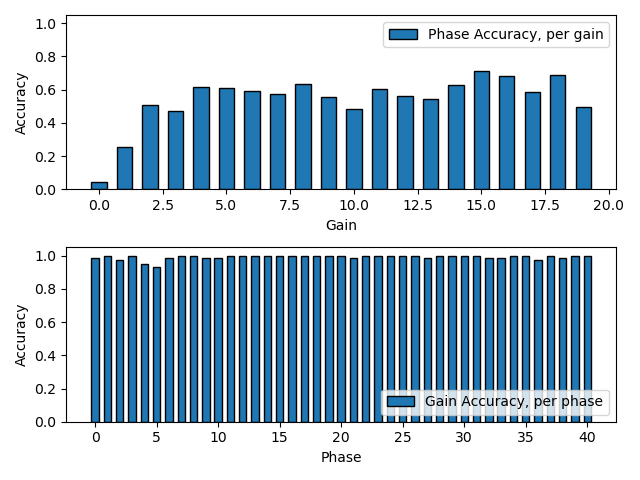

In [106]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=2)
plt.sca(ax1)
plt.bar(np.arange(len(z_phase[0])), z_phase[0], width=0.6, edgecolor='black', color='tab:blue',
         label='Phase Accuracy, per gain')
plt.ylim(0, 1.05)
plt.xlabel('Gain')
plt.ylabel('Accuracy')
plt.legend()

plt.sca(ax2)
plt.bar(np.arange(len(z_gain[0])), z_gain[0], width=0.6, edgecolor='black', color='tab:blue',
         label='Gain Accuracy, per phase')
plt.ylim(0, 1.05)
plt.xlabel('Phase')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
# plt.title('Gain prediction accuracy, per phase')

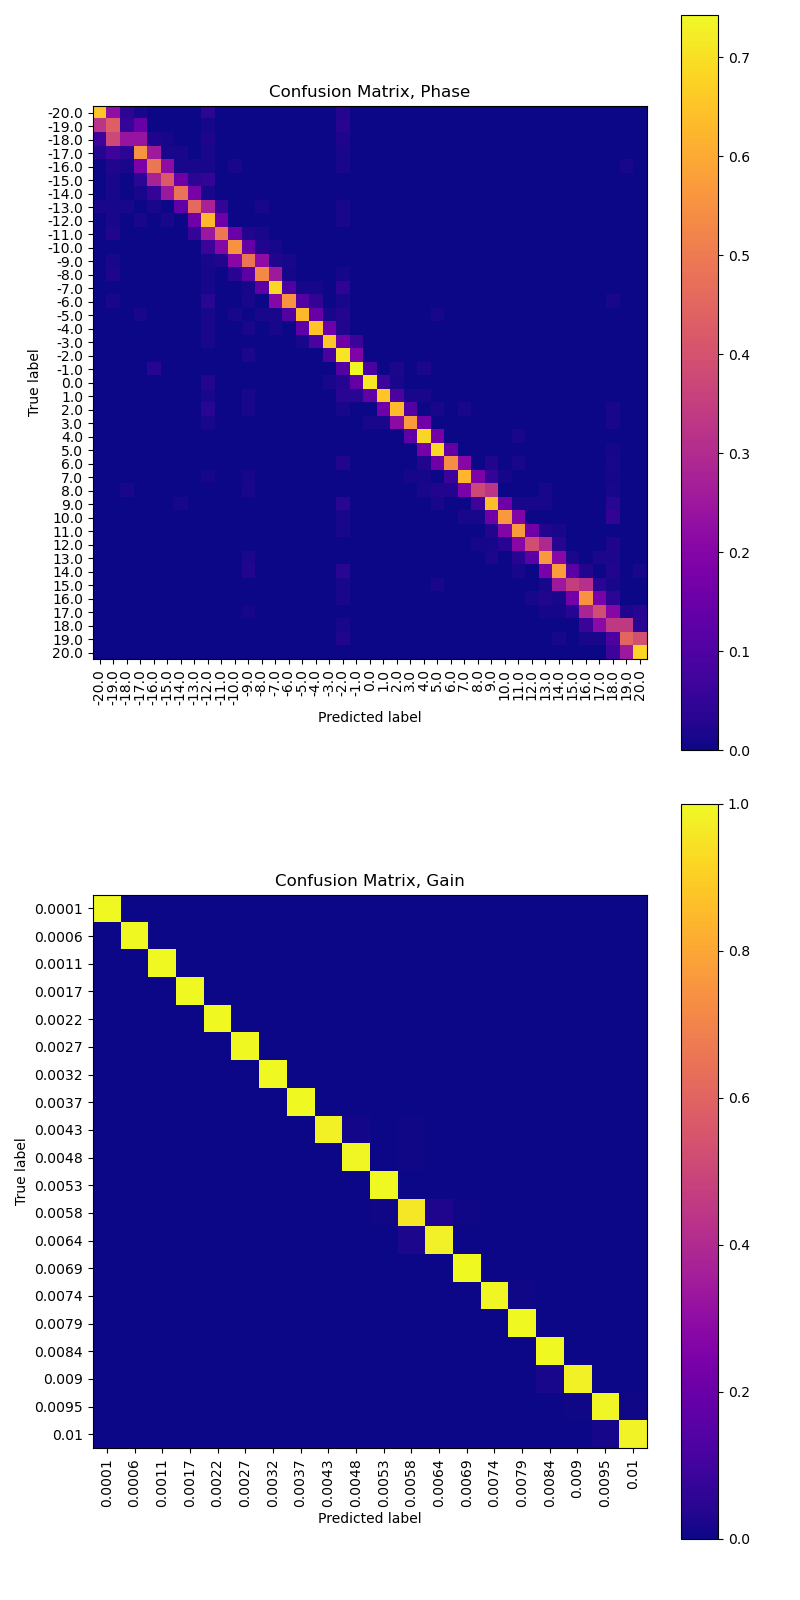

In [130]:
# show confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
fig, (ax1, ax2) = plt.subplots(figsize=(8, 16), nrows=2)
ax1.set_title('Confusion Matrix, Phase')
ConfusionMatrixDisplay.from_predictions(y_validate[:, 0], y_pred_phase,
                                        xticks_rotation='vertical', ax=ax1,
                                        normalize='true', include_values=False,
                                        cmap='plasma', display_labels=phi_encoder.classes_)
plt.sca(ax1)
plt.tight_layout()

ax2.set_title('Confusion Matrix, Gain')
ConfusionMatrixDisplay.from_predictions(y_validate[:, 1], y_pred_gain,
                                        xticks_rotation='vertical', ax=ax2,
                                        include_values=False, normalize='true',
                                        cmap='plasma',
                                        display_labels=np.round(gain_encoder.classes_, 4))
plt.sca(ax2)
plt.tight_layout()


In [108]:
# Convert from category to value
y_pred_phase_descaled = phi_encoder.inverse_transform(y_pred_phase)
y_pred_gain_descaled = gain_encoder.inverse_transform(y_pred_gain)
y_pred_descaled = np.array([y_pred_phase_descaled, y_pred_gain_descaled]).T.reshape(-1, 2)

In [109]:
from sklearn.metrics import r2_score, mean_absolute_error

r2_pred = r2_score(y_validate_original, y_pred_descaled,
                   multioutput='raw_values')
mae_pred = mean_absolute_error(y_validate_original, y_pred_descaled,
                               multioutput='raw_values')
# mape_pred = mean_absolute_percentage_error(y_validate_original, y_pred_descaled,
#                                       multioutput='raw_values')

r2_opt = r2_score(y_validate_original, y_optimizer,
                   multioutput='raw_values')
mae_opt = mean_absolute_error(y_validate_original, y_optimizer,
                               multioutput='raw_values')
# mape_opt = mean_absolute_percentage_error(y_validate_original, y_optimizer,
#                                       multioutput='raw_values')
print('R2\tPhase\tGain')
print('NeuralNet: ', r2_pred)
print('Optimizer:', r2_opt)

print('MAE\tPhase\tGain')
print('NeuralNet: ', mae_pred)
print('Optimizer:', mae_opt)

# print('MAPE\tPhase\tGain')
# print('NeuralNet: ', mape_pred)
# print('Optimizer:', mape_opt)

R2	Phase	Gain
NeuralNet:  [0.95524975 0.99966497]
Optimizer: [ 0.13036792 -0.13919803]
MAE	Phase	Gain
NeuralNet:  [8.91463415e-01 4.13029525e-06]
Optimizer: [9.58858419e+00 2.62925465e-03]
